In [1]:
#### IMPORT ####

# Import necessary libraries
import os, sys
os.chdir("..")      # move to project root
sys.path.append("src")  # allow utils import

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from wordcloud import WordCloud
from src.utils import save_plot

In [2]:
#### LOADING FILES ####

# Create a dataframe from a CSV file
df = pd.read_csv("data/amazon.csv")

# Display Max Columns and Width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
#### DATA INSPECTION ####

# A sneek peek at the data
print('\nFirst 5 dataset:',df.head())
print('\n\nColumns:',df.columns)
print('\nInfo:',df.info())

# Shape of the dataframe
print("\nDataframe Shape:", df.shape)
print("\nNumber of Duplicates:", df.duplicated().sum())
print("\nNumber of Missing Values:\n", df.isnull().sum())


First 5 dataset:    product_id                                       product_name                                           category discounted_price actual_price discount_percentage rating rating_count                                      about_product                                            user_id                                          user_name                                          review_id                                       review_title                                     review_content                                           img_link                                       product_link
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...  Computers&Accessories|Accessories&Peripherals|...             ₹399       ₹1,099                 64%    4.2       24,269  High Compatibility : Compatible With iPhone 12...  AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...  Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...  R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K..

In [4]:
#### CLEANING DATA ####

# 1. Clean Prices (Remove ₹ and commas)
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

# 2. Clean Discount % (Remove % and convert to decimal)
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float) / 100

# 3. Clean Rating and Rating Count
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = df['rating_count'].str.replace(',', '').astype(float)

# 4. Simplify Categories (Extract the first word)
df['main_category'] = df['category'].str.split('|').str[0]

# Remove empty rows
df = df.dropna(subset=['rating', 'rating_count', 'actual_price'])

# Finding unusual values in the rating column
print("\nRating value counts:", df['rating'].value_counts())

# check the strange row
print(df.query('\nrating == "|" '))

# Changing the unusual value
df['rating'] = df['rating'].replace('|', '3.9').astype(float) 
print(df.dtypes)

# Descriptive statistics
print("\nDescriptive Statistics:\n", df.describe())

# Data wrangling: Handling missing values
print('\nMissing values percentage:\n', round(df.isnull().mean() * 100, 2).sort_values(ascending=False))



Rating value counts: rating
4.1    244
4.3    230
4.2    228
4.0    181
3.9    123
4.4    123
3.8     86
4.5     75
3.7     42
3.6     35
3.5     26
4.6     17
3.3     16
3.4     10
4.7      6
3.1      4
3.0      3
4.8      3
3.2      2
5.0      2
2.8      2
2.3      1
2.0      1
2.6      1
2.9      1
Name: count, dtype: int64
Empty DataFrame
Columns: [product_id, product_name, category, discounted_price, actual_price, discount_percentage, rating, rating_count, about_product, user_id, user_name, review_id, review_title, review_content, img_link, product_link, main_category]
Index: []
product_id                 str
product_name               str
category                   str
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
about_product              str
user_id                    str
user_name                  str
review_id                  str
review_title               str
revie

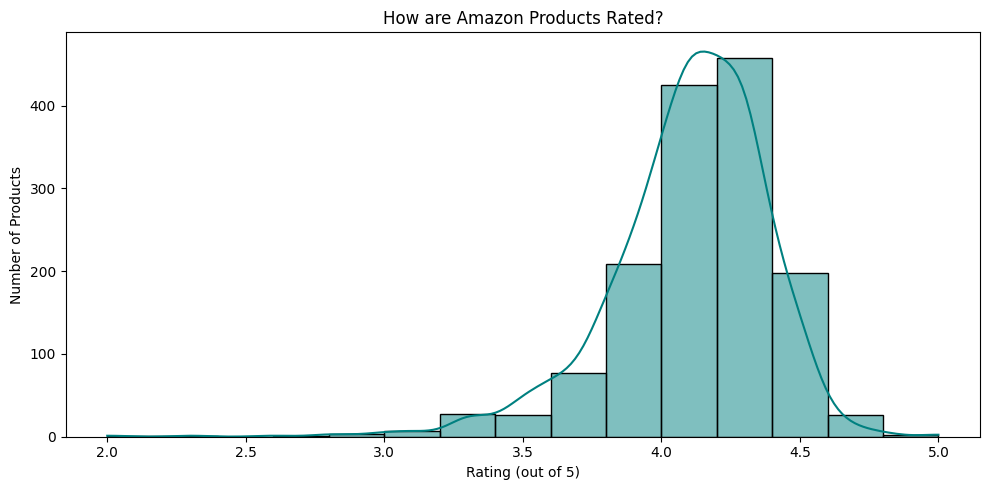

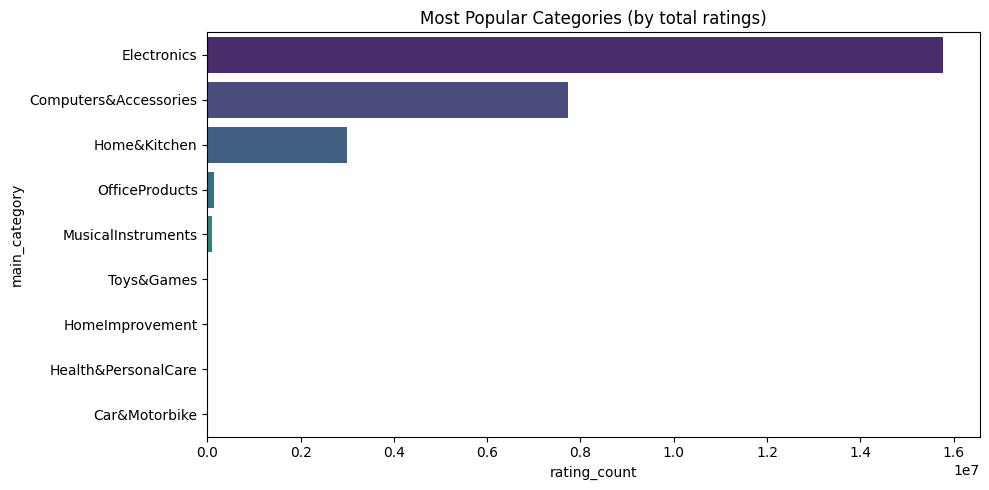

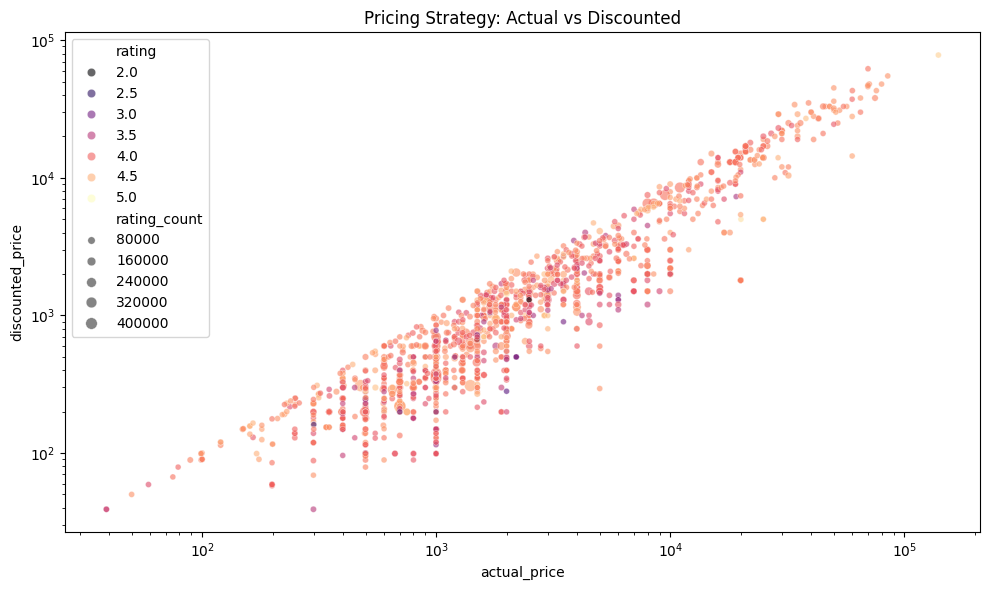

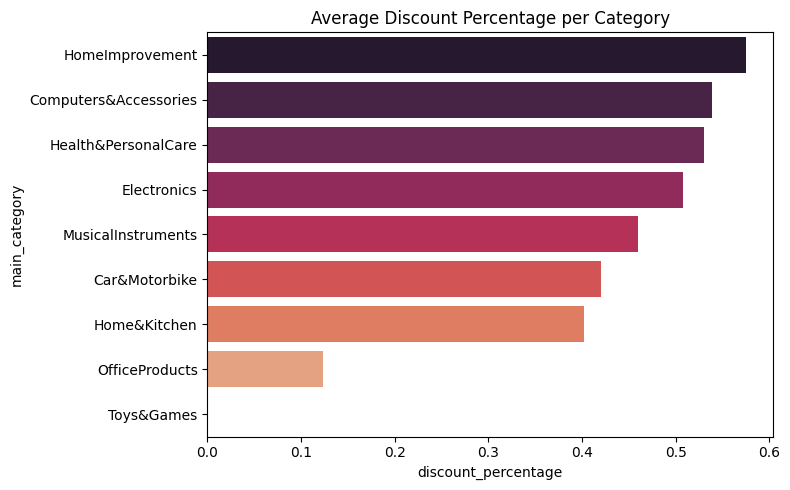

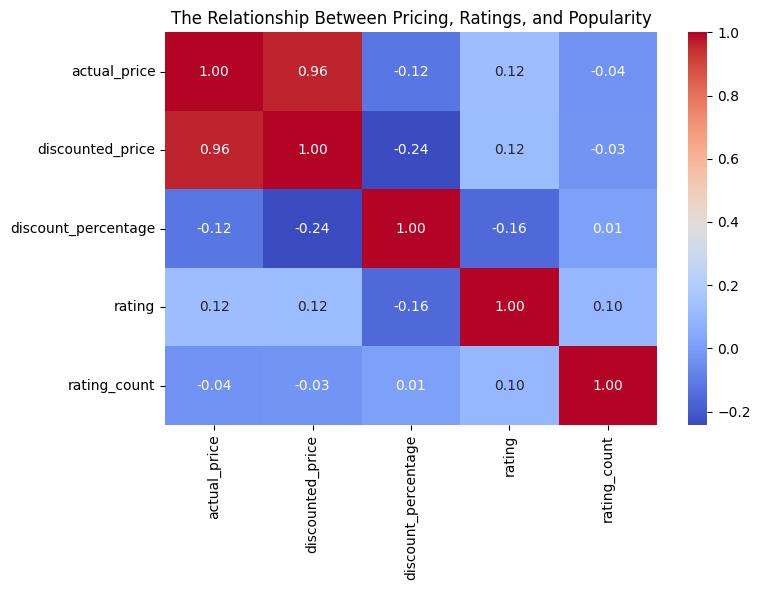

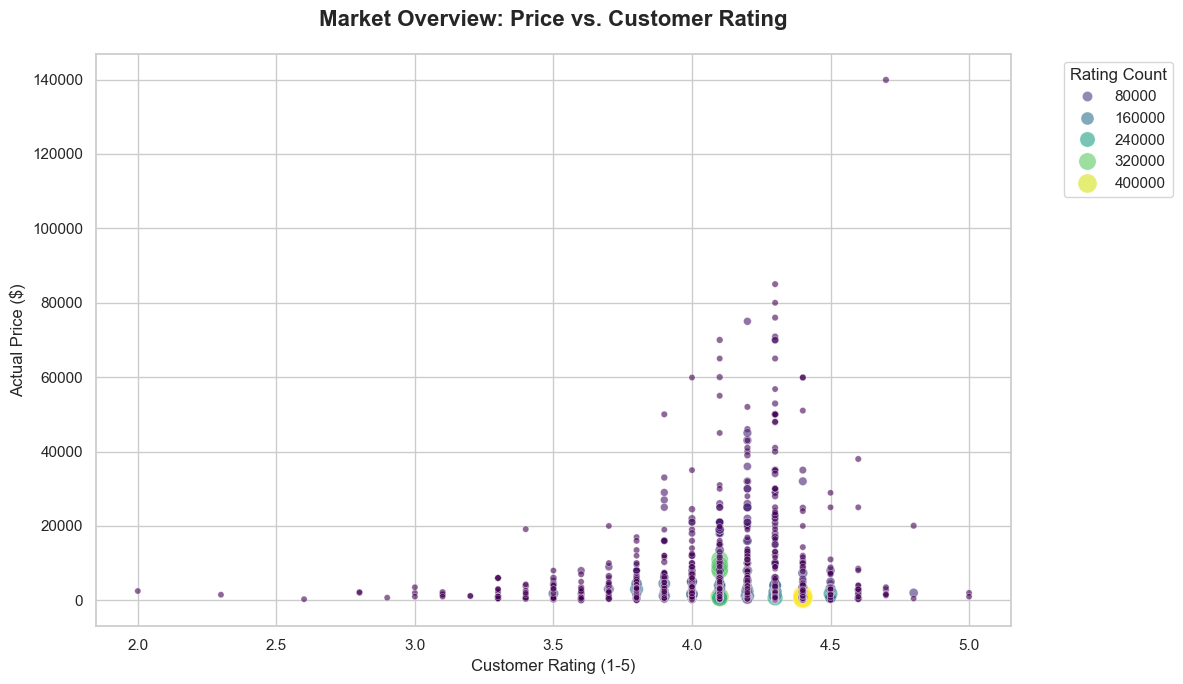

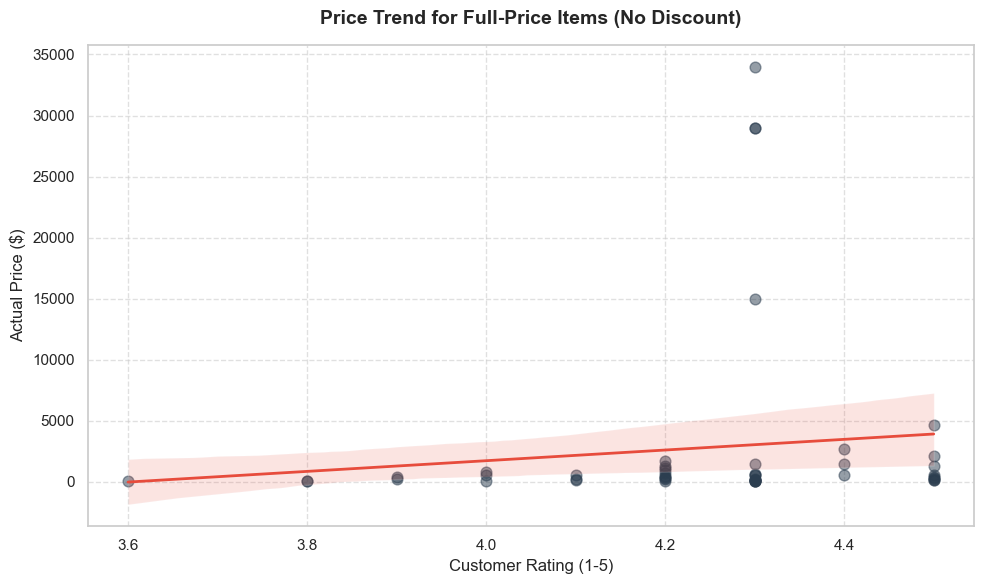

In [5]:
#### BASIC VISUALIZATION ####

# Customer Satisfaction: By Rating Distribution
# The Insight: This tells you if the marketplace is healthy. If most ratings are above 4.0, customers are generally satisfied with their purchases.
# Why it matters: You can identify if "average" products are rare or if "perfection" is common.

plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=15, kde=True, color='teal')
plt.title('How are Amazon Products Rated?')
plt.xlabel('Rating (out of 5)')
plt.ylabel('Number of Products')
plt.tight_layout()
save_plot("Amazon_products_rating_distribution")
plt.show()


# The Sales Engine: Top 10 Categories 
# The Insight: Since we don't have "Sales Volume," the Rating Count is our best proxy. This graph reveals which categories are the most purchased.
# Observation: Electronics and Computer Accessories usually dominate this chart.

plt.figure(figsize=(10,5))
top_catagories = df.groupby('main_category')['rating_count'].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=top_catagories, x='rating_count', y='main_category', hue ='main_category', palette='viridis', legend=False)
plt.title('Most Popular Categories (by total ratings)')
plt.tight_layout()
save_plot("Top10_popular_category")
plt.show()


# The Strategy Map: (Actual Price vs. Discounted Price)
# The Insight: This scatter plot shows the pricing strategy.
# Dots further from the diagonal line have massive discounts. Color-coding by Rating lets you see if expensive items have better ratings than cheaper ones.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='actual_price', y='discounted_price', hue='rating', size='rating_count', palette='magma', alpha=0.6)
plt.xscale('log') # Prices vary widely, so log scale keeps it neat
plt.yscale('log')
plt.title('Pricing Strategy: Actual vs Discounted')
plt.tight_layout()
save_plot("Pricing_strategy")
plt.show()


# Discount Aggression by Category
# The Insight: This reveals which departments are in a "Price War."
# Why it matters: If "Home Improvement" has a 60% average discount while "Office Products" only has 15%, you know where the competition is fiercest.

plt.figure(figsize=(8,5))
avg_discount = df.groupby('main_category')['discount_percentage'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data=avg_discount, x='discount_percentage', y='main_category', hue ='main_category', legend=False, palette='rocket')
plt.title('Average Discount Percentage per Category')
plt.tight_layout()
save_plot("Avg_discount_percent_per_category")
plt.show()


# Metric Correlation Heatmap
# The Insight: This shows the mathematical relationship between all your variables.
# The "Gold" Insight: Check the correlation between rating and discount_percentage. If it's negative, it means highly discounted products often have lower quality/ratings.

plt.figure(figsize=(8, 6))
corr = df[['actual_price', 'discounted_price', 'discount_percentage', 'rating', 'rating_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('The Relationship Between Pricing, Ratings, and Popularity')
plt.tight_layout()
save_plot("Relation_btw_pricing_rating_popularity")
plt.show()


# Distribution of Price vs Rating
# We use hue and size for rating_count to show 'popularity' depth

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=df, 
    x='rating', 
    y='actual_price', 
    hue='rating_count', 
    size='rating_count',
    sizes=(20, 200),
    palette='viridis', 
    alpha=0.6,
    edgecolor='w'
)
plt.title('Market Overview: Price vs. Customer Rating', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Customer Rating (1-5)', fontsize=12)
plt.ylabel('Actual Price ($)', fontsize=12)

# Move legend outside to keep the plot clean
plt.legend(title='Rating Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
save_plot("Pricing_vs_customer_rating")
plt.show()


# Price vs Rating Trend (No Discount)
# Using regplot to show the correlation/trend

plt.figure(figsize=(10, 6))
no_discount_df = df[df['discount_percentage'] == 0]
sns.regplot(
    data=no_discount_df, 
    x='rating', 
    y='actual_price', 
    scatter_kws={'alpha':0.5, 's':60, 'color':'#2c3e50'},
    line_kws={'color':'#e74c3c', 'lw':2}
)
plt.title('Price Trend for Full-Price Items (No Discount)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Customer Rating (1-5)', fontsize=12)
plt.ylabel('Actual Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_plot("Actual_pricing_trend")
plt.show()

In [6]:
#### DATA LABELING ####
  
# Data label encoding for categorical variables
le_main = LabelEncoder()
le_product_id = LabelEncoder()
le_category = LabelEncoder()
le_review_id = LabelEncoder()
le_review_content = LabelEncoder()
le_product_name = LabelEncoder()
le_user_name = LabelEncoder()
le_about_product = LabelEncoder()

le_user_id = LabelEncoder()
le_img_link = LabelEncoder()
le_product_link = LabelEncoder()

df['main_category'] = le_main.fit_transform(df['main_category'])
df['product_id'] = le_product_id.fit_transform(df['product_id'])
df['category'] = le_category.fit_transform(df['category'])
df['review_id'] = le_review_id.fit_transform(df['review_id'])
df['review_content'] = le_review_content.fit_transform(df['review_content'])
df['product_name'] = le_product_name.fit_transform(df['product_name'])
df['user_name'] = le_user_name.fit_transform(df['user_name'])
df['about_product'] = le_about_product.fit_transform(df['about_product'])
df['user_id'] = le_user_id.fit_transform(df['user_id'])
df['img_link'] = le_img_link.fit_transform(df['img_link'])
df['product_link'] = le_product_link.fit_transform(df['product_link'])


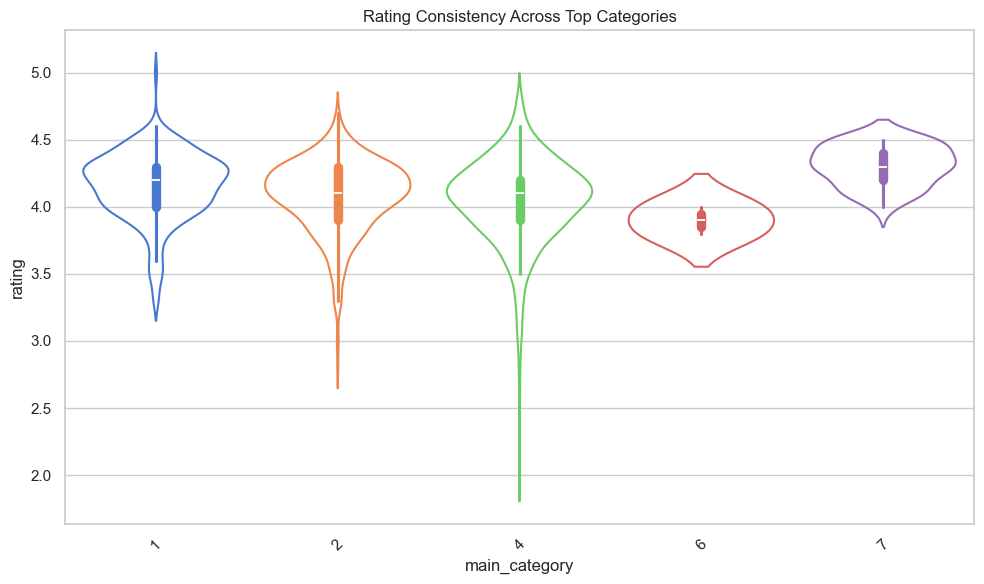

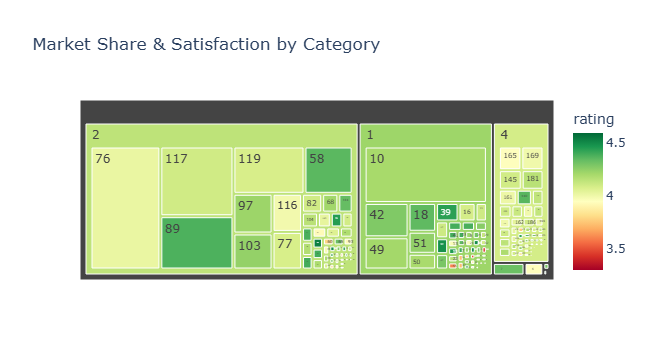

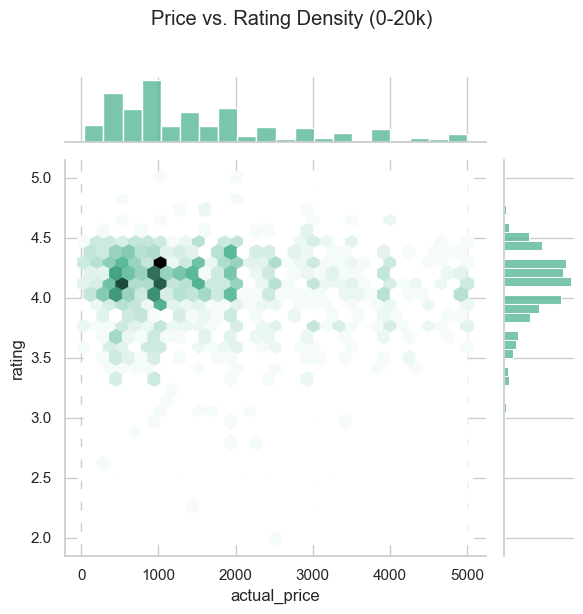

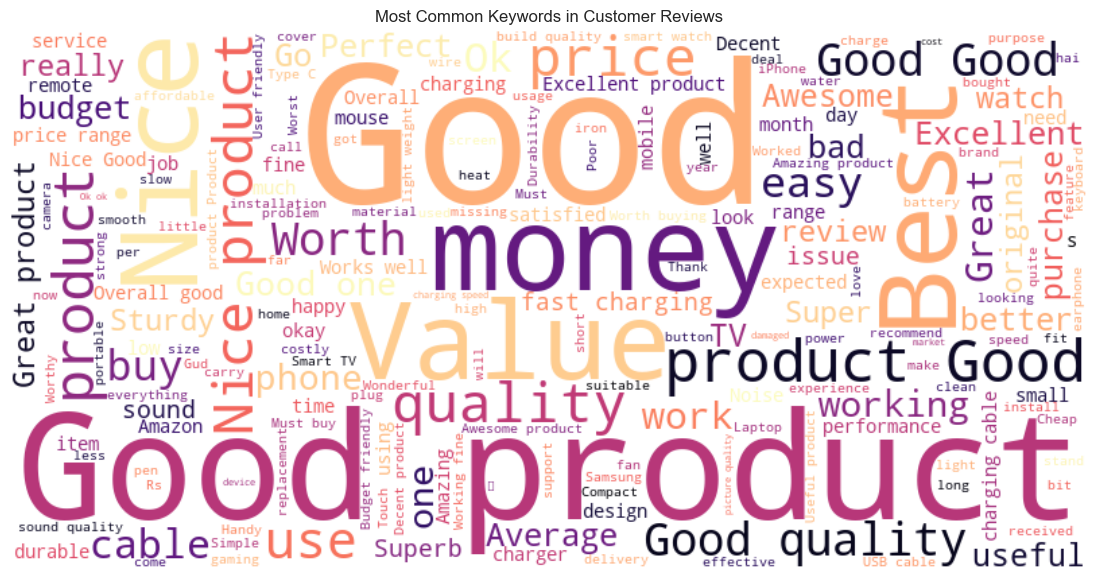

C:\Users\Dell\AppData\Local\Temp\ipykernel_4488\4057473821.py:94: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



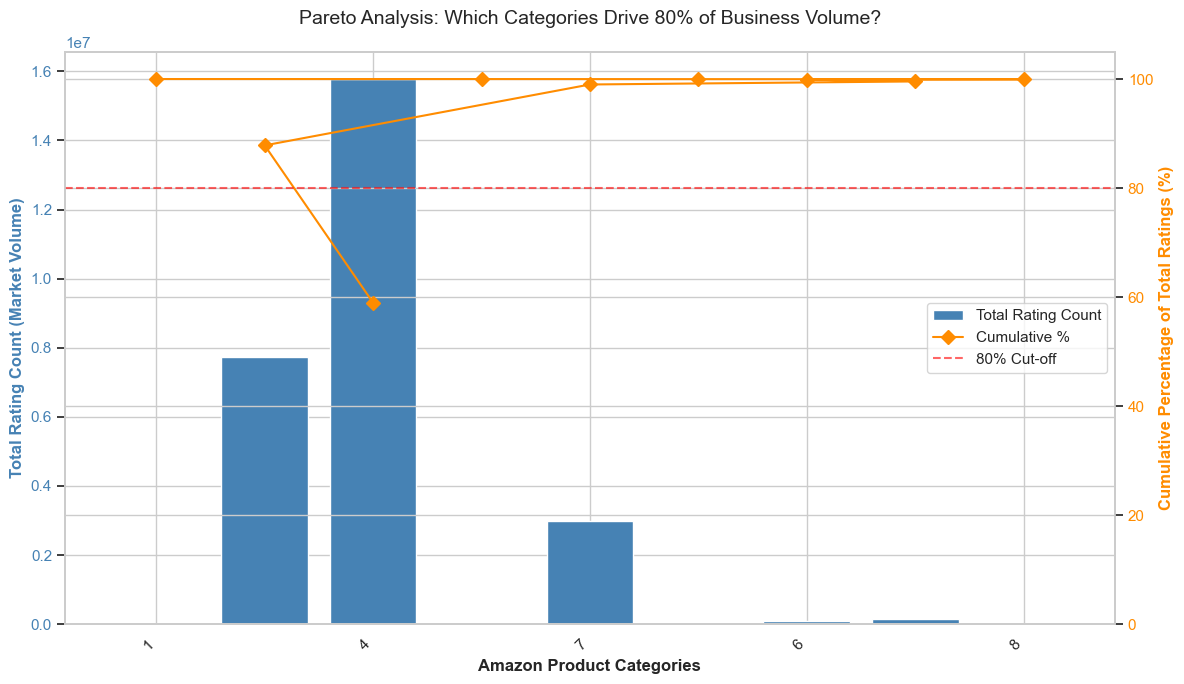

In [7]:
#### PROFESSSIONAL GRAPHS ####

# Violin Plots (Distribution & Density)
# While a bar chart shows the "average," a Violin Plot shows the entire "shape" of the data.
# The Insight: It reveals if a category has a consistent rating (a thin, tall violin) or if it's highly controversial with both 1-star and 5-star reviews (a "fat" violin with two bumps).
# Professional Use: To detect risk. A category with high average ratings but a wide distribution is "risky" for a seller.

plt.figure(figsize=(10, 6))
# Showing the top 5 main categories to keep it clean
top_5_cats = df['main_category'].value_counts().nlargest(5).index
sns.violinplot(data=df[df['main_category'].isin(top_5_cats)], 
               x='main_category', y='rating',hue ='main_category', legend=False, fill=False, palette="muted")
plt.title('Rating Consistency Across Top Categories')
plt.xticks(rotation=45)
plt.tight_layout() 
save_plot("Top_category_by_rating")
plt.show()



# Treemaps (Hierarchical Market Share)
# Amazon categories are hierarchical (e.g., Electronics > Accessories > Cables). A Treemap represents the "Market Share" of each category using nested rectangles.
# The Insight: The size of the box represents the Rating Count (volume), and the color represents the Average Rating (satisfaction).
# Professional Use: To quickly identify which sub-niches are "High Volume, Low Satisfaction" (opportunities for new products).

px.treemap(df, path=['main_category', 'category'], values='rating_count',
                  color='rating', color_continuous_scale='RdYlGn',
                  title='Market Share & Satisfaction by Category').show()


# Joint Plots (Relationship Density)
# When you have over 1,000 products, a scatter plot becomes a "cloud" of dots where you can't see where most products sit. A Joint Plot adds histograms to the sides to show density.
# The Insight: It identifies the "Sweet Spot." For example, do most highly-rated products sit in the ₹500–₹1,000 range?
# Professional Use: To define Pricing Brackets.

df_filtered = df[(df['actual_price'] >= 0) & (df['actual_price'] <= 5000)].copy()
sns.jointplot(data=df_filtered, x='actual_price', y='rating', kind="hex", color="#4CB391")
plt.suptitle('Price vs. Rating Density (0-20k)', y=1.02)
plt.tight_layout()
save_plot("Price_vs_rating_realtionship_density")
plt.show()


# Word Clouds (Textual Theme Analysis)
# Since you have review_title and about_product, you can visualize what customers actually care about.
# The Insight: It highlights words like "Fast," "Durable," "Poor Quality," or "Overpriced" directly from the customer's mouth.
# Professional Use: For Sentiment Analysis and identifying product pain points.
# Combine all review titles into one big string

text = " ".join(title for title in df.review_title.astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Keywords in Customer Reviews')
save_plot("Word_cloud")
plt.show()


# Pareto Chart (The 80/20 Rule)
# A Pareto chart combines a bar chart and a line graph to show which categories contribute to 80% of your total engagement (Rating Count).
# The Insight: It proves that a tiny number of categories (usually the top 2-3) drive almost all the traffic on the platform.
# Professional Use: For Resource Allocation—focusing marketing efforts where the impact is highest.

# 1. Prepare the data (Ensure you are grouping by the TEXT names, not the encoded numbers)
# Use 'main_category' which you created before the encoding step
cat_counts = df.groupby('main_category')['rating_count'].sum().sort_values(ascending=False)
cum_percentage = cat_counts.cumsum() / cat_counts.sum() * 100

# 2. Create the Figure and First Axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Primary Axis: Bar Chart (Volume)
ax1.bar(cat_counts.index, cat_counts, color="steelblue", label='Total Rating Count')
ax1.set_xlabel('Amazon Product Categories', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Rating Count (Market Volume)', fontsize=12, color='steelblue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')

# 3. Create the Second Axis (Percentage)
ax2 = ax1.twinx()
ax2.plot(cat_counts.index, cum_percentage, color="darkorange", marker="D", ms=7, label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage of Total Ratings (%)', fontsize=12, color='darkorange', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='darkorange')

# 4. Add the "80% Rule" Reference Line
# This visually separates the "Critical Categories" from the rest
ax2.axhline(80, color="red", linestyle="--", alpha=0.6, label='80% Cut-off')
ax2.set_ylim(0, 105) 

# 5. Title and Formatting
plt.title('Pareto Analysis: Which Categories Drive 80% of Business Volume?', fontsize=14, pad=20)

# Rotate labels 45 degrees so they don't overlap or get cut off
ax1.set_xticklabels(cat_counts.index, rotation=45, ha='right')

# Combine legends into one box
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.tight_layout()
save_plot("Pareto_analysis")
plt.show()

# Set the labels back
le_review_title = LabelEncoder()
df['review_title'] = le_review_title.fit_transform(df['review_title'])



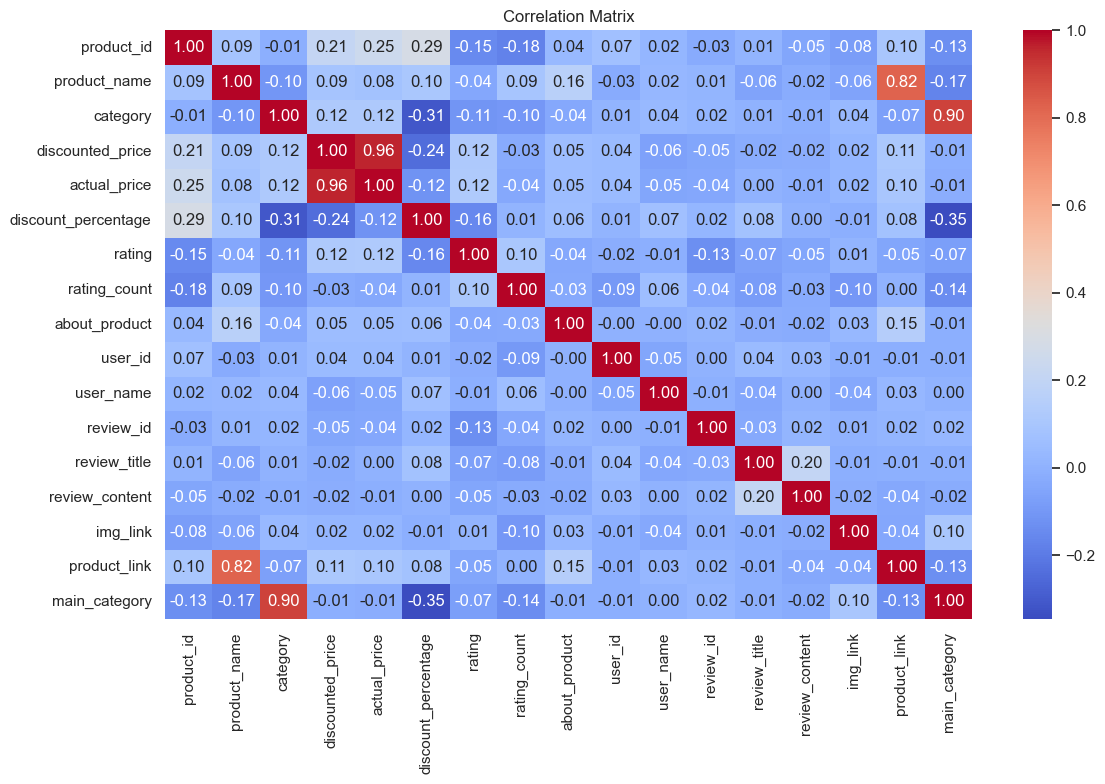

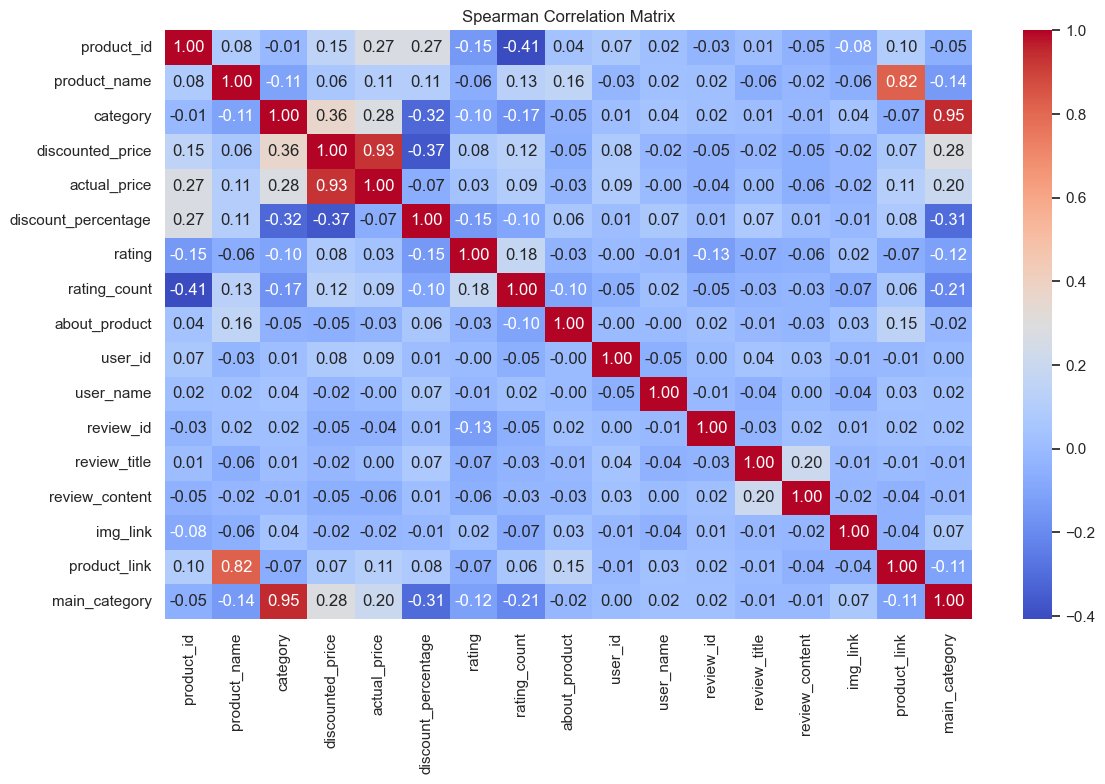


Correlation Coefficient between Actual Price and Rating: 0.12246744457918224


In [8]:
#### CORRELATION ANALYSIS ####

# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
save_plot("Correlation_matrix")
plt.show()

# Spearman correlation
spearman_corr = df.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.tight_layout()
save_plot("Spearman_correlation_matrix")
plt.show()

correlationCoefficients = np.corrcoef(df['actual_price'], df['rating'])
print("\nCorrelation Coefficient between Actual Price and Rating:", correlationCoefficients[0, 1])


In [9]:
#### GROUPING & AGGREGATION ####

# Group by category and calculate mean rating
category_rating = df.groupby('category')['rating'].mean()
print("\nMean Rating by Category:\n", category_rating)

# Mean rating by category
mean_sales_by_category = df.groupby('category')['rating'].mean()
print("\nMean Sales by category:", mean_sales_by_category)

median_sales_by_age = df.groupby('review_content')['rating'].median()
print('\nMedian sales by age:',median_sales_by_age)

std_price_by_brand = df.groupby('product_name')['actual_price'].std()
print('\nThe satistics are:\n',std_price_by_brand)




Mean Rating by Category:
 category
0      3.800000
1      4.150000
2      3.500000
3      3.600000
4      4.050000
         ...   
206    4.250000
207    4.150000
208    4.300000
209    4.133333
210    4.300000
Name: rating, Length: 211, dtype: float64

Mean Sales by category: category
0      3.800000
1      4.150000
2      3.500000
3      3.600000
4      4.050000
         ...   
206    4.250000
207    4.150000
208    4.300000
209    4.133333
210    4.300000
Name: rating, Length: 211, dtype: float64

Median sales by age: review_content
0       4.1
1       3.9
2       4.3
3       4.3
4       3.8
       ... 
1204    4.0
1205    4.3
1206    4.3
1207    4.5
1208    4.3
Name: rating, Length: 1209, dtype: float64

The satistics are:
 product_name
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1329    NaN
1330    NaN
1331    NaN
1332    NaN
1333    0.0
Name: actual_price, Length: 1334, dtype: float64
